In [1]:
import cv2

import os

import math

from time import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

from tqdm.auto import tqdm

import itertools

import random

import re

import sys
sys.path.append("./lib/")

from utils import GradualWarmupScheduler
from models import FeaturesModelPt5v0BN, GlanceModelGSv1

In [2]:
# Some constans 
img_sz = 32  # Size of input image
batch_size = 256

num_workers = 6

In [3]:
logs = []

def print_l(s):
    logs.append(s)
    print(s)

In [4]:
class BigMNIST(datasets.MNIST):
    half_sz = 28 // 2    
    
    """
    DataSet for using in pytorch DataLoader
    """
    def __init__(self, root, train, download, transform, img_sz):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.img_sz = img_sz

    def __getitem__(self, i):
        X_, lbl = super().__getitem__(i)
        X = torch.zeros(((1, self.img_sz, self.img_sz)))
        h_sz = self.half_sz
        if h_sz == self.img_sz - h_sz:
            y, x = h_sz, h_sz
        else:
            y, x = torch.randint(h_sz, self.img_sz - h_sz, (2,))
        
        X[0, y-h_sz:y+h_sz, x-h_sz:x+h_sz] = X_[0, :, :]
        return X, lbl, y, x

In [5]:
kwargs = {'num_workers': num_workers, 'pin_memory': False}
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    BigMNIST('./data', train=True, download=True, transform=transform, img_sz=img_sz),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    BigMNIST('./data', train=False, download=True, transform=transform, img_sz=img_sz),
    batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
model = GlanceModelGSv1(
    FeaturesModelPt5v0BN,
    img_sz=img_sz,
    inp_channels=1,
    num_classes=10,
    f_sz=64,
    p_sz=32,
    h_sz=512,
    layers_num=2,
    steps=5,
    r_dropout=0.25
)

In [7]:
device = torch.device('cuda:0')

In [8]:
model.to(device);

In [9]:
sum([p.numel() for p in model.parameters()])

3432672

In [10]:
sum([p.numel() for p in model.features_model_g.parameters()])

24416

In [11]:
sum([p.numel() for p in model.separate_parameters(no_decay=False)])

3415744

In [12]:
sum([p.numel() for p in model.separate_parameters(no_decay=True)])

16928

In [13]:
hard = True
tau = 1.0
add_gumbels = False
debug = False

epochs = 50
wup_mult = 8.0
wup_epochs = 5

In [14]:
optimizer = optim.AdamW(
    [
        {'params': model.separate_parameters(no_decay=False)},
        {'params': model.separate_parameters(no_decay=True), 'weight_decay': 0}
    ],
    lr=0.001/wup_mult, 
    weight_decay=0.1
)

In [15]:
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1)
scheduler = GradualWarmupScheduler(optimizer, multiplier=wup_mult, total_epoch=wup_epochs, after_scheduler=cosine_scheduler)

loss_stat = []

for e in tqdm(range(0, epochs)):
    for is_train in [True, False]:
        all_losses, all_preds, all_targets = [], [], []

        model.train(is_train)

        with torch.set_grad_enabled(is_train):
            for imgs, target, *_ in (train_loader if is_train else test_loader):

                imgs, target = [v.to(device) for v in (imgs, target)]

                logits = model(imgs, is_train=is_train, hard=hard, tau=tau, add_gumbels=add_gumbels)

                loss = F.cross_entropy(logits, target)

                all_losses.append(loss.item())
                all_preds.extend(logits.argmax(-1).detach().cpu().numpy().tolist())
                all_targets.extend(target.cpu().numpy().tolist())

                if is_train:
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    # torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                    loss_stat.append(loss.item())
                    optimizer.step()
                    optimizer.zero_grad()

        all_losses, all_preds, all_targets = \
            [np.array(n) for n in [all_losses, all_preds, all_targets]]

        acc = (all_preds == all_targets).mean()

        print_l(f"{f'{e:03d}.' if is_train else '    '} {'train' if is_train else ' test'} loss: {all_losses.mean():.04f}, acc: {acc:.04f}, lr: {optimizer.param_groups[0]['lr']:.06f}")

    scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]

000. train loss: 0.8534, acc: 0.7218, lr: 0.000125
      test loss: 0.4144, acc: 0.8693, lr: 0.000125
001. train loss: 0.3624, acc: 0.8861, lr: 0.000300
      test loss: 0.2748, acc: 0.9145, lr: 0.000300
002. train loss: 0.2668, acc: 0.9167, lr: 0.000475
      test loss: 0.2298, acc: 0.9257, lr: 0.000475
003. train loss: 0.2273, acc: 0.9276, lr: 0.000650
      test loss: 0.2174, acc: 0.9328, lr: 0.000650
004. train loss: 0.2042, acc: 0.9354, lr: 0.000825
      test loss: 0.1766, acc: 0.9450, lr: 0.000825
005. train loss: 0.1853, acc: 0.9408, lr: 0.001000
      test loss: 0.2111, acc: 0.9361, lr: 0.001000


/home/ruslan/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


006. train loss: 0.1672, acc: 0.9478, lr: 0.001000
      test loss: 0.2112, acc: 0.9372, lr: 0.001000
007. train loss: 0.1475, acc: 0.9548, lr: 0.000999
      test loss: 0.1825, acc: 0.9435, lr: 0.000999
008. train loss: 0.1364, acc: 0.9577, lr: 0.000996
      test loss: 0.1216, acc: 0.9631, lr: 0.000996
009. train loss: 0.1246, acc: 0.9603, lr: 0.000991
      test loss: 0.1530, acc: 0.9536, lr: 0.000991
010. train loss: 0.1179, acc: 0.9634, lr: 0.000984
      test loss: 0.1290, acc: 0.9602, lr: 0.000984
011. train loss: 0.1068, acc: 0.9666, lr: 0.000976
      test loss: 0.0997, acc: 0.9689, lr: 0.000976
012. train loss: 0.0995, acc: 0.9691, lr: 0.000965
      test loss: 0.1042, acc: 0.9673, lr: 0.000965
013. train loss: 0.0944, acc: 0.9702, lr: 0.000952
      test loss: 0.1236, acc: 0.9617, lr: 0.000952
014. train loss: 0.0902, acc: 0.9717, lr: 0.000938
      test loss: 0.1060, acc: 0.9655, lr: 0.000938
015. train loss: 0.0803, acc: 0.9744, lr: 0.000922
      test loss: 0.0871, acc: 0

In [16]:
exp_name = f"mnist_lstm2x512_pt{model.pt_sz}_f{model.f_sz}_s{model.steps}{'_gauss' if model.gauss else ''}"

In [17]:
torch.save(model.state_dict(), f"./weights/{exp_name}.pth")

In [18]:
# model.load_state_dict(torch.load("./weights/mnist_lstm2x512_pt5_f64_s5.pth"))

In [19]:
model.eval();

In [20]:
%%time
with torch.no_grad():
    all_preds, all_targets = [], []
    
    for imgs, target, *_ in test_loader:
        imgs, target = [v.to(device) for v in (imgs, target)]
        
        logits, (all_p_next_poses, all_next_poses, all_next_patches, all_h_states) = model(imgs, debug=True)

        all_logits = torch.stack([model.predict_model(h) for h in all_h_states], dim=0)
        
        all_preds.extend(logits.argmax(-1).cpu().numpy().tolist())
        all_targets.extend(target.cpu().numpy().tolist())      
        
        break

    all_preds, all_targets = [np.array(n) for n in [all_preds, all_targets]]

    acc = (all_preds == all_targets).mean()
        
    print(f"test acc: {acc:.04f}")

test acc: 0.9961
CPU times: user 23.1 ms, sys: 124 ms, total: 148 ms
Wall time: 244 ms


In [21]:
np.where((all_preds != all_targets))[0]

array([247])

In [22]:
n = 4

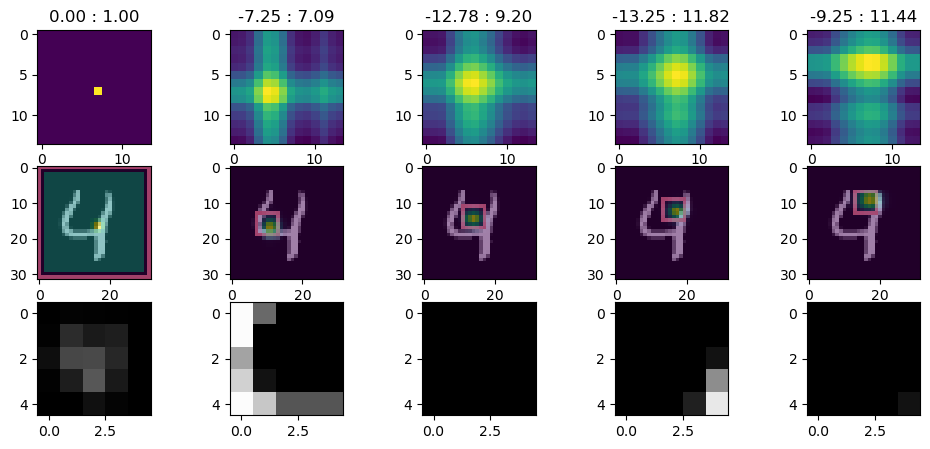

In [23]:
img_h, img_w = imgs.shape[-2:]
fig, axs = plt.subplots(3, len(all_p_next_poses), figsize=(12, 5))
for i, ax in enumerate(axs[0]):
    ax.imshow(all_p_next_poses[i][n].cpu().view(model.grid_sz, model.grid_sz));
    ax.set_title(f"{all_p_next_poses[i][n].min():.02f} : {all_p_next_poses[i][n].max():.02f}");
    
for i, ax in enumerate(axs[1]):
    img = np.repeat(imgs[n, 0].cpu().numpy()[..., None], 3, -1)
    if i == 0:
        py0, px0, py1, px1 = 1, 1, img_h-1, img_w-1
    else:
        py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy()
    cv2.rectangle(img, (px0-1, py0-1), (px1, py1), (1, 0.5, 0.5), 1)
    ax.imshow(img, cmap='gray', alpha=1.0, vmin=0, vmax=1.0);
    p = model.pt_start + model.pt_sz//2
    tmp = F.interpolate(
        (all_p_next_poses[i][n].cpu()).softmax(-1).view(1, 1, model.grid_sz, model.grid_sz), 
        size=None, scale_factor=model.pt_step,
        mode='bilinear',
        align_corners=True
    )[0, 0]
    t_h, t_w = tmp.shape[-2:]
    tmp2 = np.zeros(imgs[n, 0].shape)
    py0, px0, py1, px1 = p, p, p+t_h, p+t_w
    tmp2[py0:py1, px0:px1] = tmp
    ax.imshow(tmp2, alpha=0.5);    
    
for i, ax in enumerate(axs[2]):
    ax.imshow(all_next_patches[i][n, 0].cpu(), cmap='gray', vmin=0, vmax=1.0)

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML, Image

In [25]:
def play_glimpses_v1(n):
    def add_title(ax, text):
        return ax.text(0.5, 1.05, text, size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    
    # fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 3))
    gs = axs[0, 0].get_gridspec()
    for ax in axs[:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, 0])    
    
    img_h, img_w = imgs.shape[-2:]
    a_ans = []
    visible_img = F.interpolate(all_next_patches[0][n].cpu()[None], (img_h, img_w), mode='nearest')[0]
    axs[0, 1].imshow(imgs[n, 0].cpu(), cmap='gray', vmin=0, vmax=1),
    for i in range(0, len(all_next_poses)):
        patch = torch.zeros((img_h, img_w))
        if i > 0:
            py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy() 
            patch[py0:py1, px0:px1] = 1.0
        visible_img = torch.stack([visible_img, (imgs[n].cpu()+0.25)*patch], dim=0).max(0)[0]
        f_ans = [
            axbig.imshow(visible_img[0], cmap='gray', vmin=0, vmax=1),
            axbig.imshow(patch, cmap='gray', alpha=0.3, vmin=0, vmax=1),
            axs[1, 1].matshow(F.softmax(all_logits[i:i+1, n], dim=-1).detach().cpu(), vmax=1.0),
            add_title(axs[1, 1], f'{all_logits[i, n].argmax()}: {all_logits[i, n].max().item():.04f}'),
        ]
        
        a_ans.append(f_ans)        
        
    axbig.axis('off')
    axs[0, 1].axis('off')

    axs[1, 1].tick_params(
        axis='both', which='both', reset=True, 
        labelbottom=True, labeltop=False, labelright=False, labelleft=False,
        bottom=True, top=False, left=False, right=False
    )

    axs[1, 1].set_xticks(range(10))

    fig.tight_layout()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.05)    

    ani = animation.ArtistAnimation(fig, a_ans, interval=1000, blit=False, repeat_delay=4000)                             

    plt.close(fig)
    
    return ani

In [26]:
HTML(play_glimpses_v1(9).to_jshtml(default_mode='loop'))

In [27]:
def play_glimpses_v2(n):
    def add_title(ax, text):
        return ax.text(0.5, 1.05, text, size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    
    fig, axs = plt.subplots(2, 3, figsize=(6, 3))
    gs = axs[1, 0].get_gridspec()
    for ax in axs[1, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    
    img_h, img_w = imgs.shape[-2:]
    a_ans = []
    visible_img = F.interpolate(all_next_patches[0][n].cpu()[None], (img_h, img_w), mode='nearest')[0]
    axs[0, 0].imshow(imgs[n, 0].cpu(), cmap='gray', vmin=0, vmax=1),
    for i in range(0, len(all_next_poses)):
        patch = torch.zeros((img_h, img_w))
        if i > 0:
            py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy() 
            patch[py0:py1, px0:px1] = 1.0
        visible_img = torch.stack([visible_img, (imgs[n].cpu()+0.25)*patch], dim=0).max(0)[0]
        f_ans = [
            axs[0, 2].imshow(all_next_patches[i][n, 0].cpu(), cmap='gray', vmin=0, vmax=1),
            axs[0, 1].imshow(visible_img[0], cmap='gray', vmin=0, vmax=1),
            axs[0, 1].imshow(patch, cmap='gray', alpha=0.3, vmin=0, vmax=1),
            axbig.matshow(F.softmax(all_logits[i:i+1, n], dim=-1).detach().cpu(), vmax=1.0),
            add_title(axbig, f'{all_logits[i, n].argmax()}: {all_logits[i, n].max().item():.04f}'),
        ]
        
        a_ans.append(f_ans)        
        
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[0, 2].axis('off')

    axbig.tick_params(
        axis='both', which='both', reset=True, 
        labelbottom=True, labeltop=False, labelright=False, labelleft=False,
        bottom=True, top=False, left=False, right=False
    )

    axbig.set_xticks(range(10))

    fig.tight_layout()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.05)    

    ani = animation.ArtistAnimation(fig, a_ans, interval=1000, blit=False, repeat_delay=4000)                             

    plt.close(fig)
    
    return ani

In [28]:
HTML(play_glimpses_v2(9).to_jshtml(default_mode='loop'))

In [29]:
ani_output_dir = f"./animations/{exp_name}_v1/"
os.makedirs(ani_output_dir, exist_ok=True)

for b in tqdm(range(imgs.size(0))):
    ani = play_glimpses_v1(b)
    ani.save(os.path.join(ani_output_dir, f"{b}.gif"))
    
ani_output_dir = f"./animations/{exp_name}_v2/"
os.makedirs(ani_output_dir, exist_ok=True)

for b in tqdm(range(imgs.size(0))):
    ani = play_glimpses_v2(b)
    ani.save(os.path.join(ani_output_dir, f"{b}.gif"))    

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]